In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC


%matplotlib inline

In [4]:
data = pd.read_csv('fer2013/fer2013.csv')
data = shuffle(data)

In [5]:
X = data['pixels']
y = data['emotion']

In [6]:
X = pd.Series([np.array(x.split()).astype(int) for x in X])
# convert one column as list of ints into dataframe where each item in array is a column
X = pd.DataFrame(np.matrix(X.tolist()))

In [8]:
# This function plots the given sample set of images as a grid with labels 
# if labels are available.
def plot_sample(S,w=48,h=48,labels=None):
    m = len(S);
  
    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)));
    display_cols = int(np.ceil(m / display_rows));
   
    fig = plt.figure()
    S = S.as_matrix()
    for i in range(0,m):
        arr = S[i,:]
        arr = arr.reshape((w,h))
        ax = fig.add_subplot(display_rows,display_cols , i+1)
        ax.imshow(arr, aspect='auto', cmap=plt.get_cmap('gray'))
        if labels is not None:
            ax.text(0,0, '{}'.format(labels[i]), bbox={'facecolor':'white', 'alpha':0.8,'pad':2})
        ax.axis('off')
    plt.show()
    
    print ('0=Angry', '1=Disgust', '2=Fear', '3=Happy', '4=Sad', '5=Surprise', '6=Neutral')

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# CALC AUC_ROC, binarizing each lable
y_b = pd.DataFrame(label_binarize(y, classes=[0,1,2,3,4,5,6]))
n_classes = y_b.shape[1]

# since the data we have is one big array, we want to split it into training
# and testing sets, the split is 70% goes to training and 30% of data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
neural_network =(100,)

In [15]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled dataset): 
# unsupervised feature extraction / dimensionality reduction

h=w=48

n_components = 150
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

eigenfaces = pca.components_.reshape((n_components, h, w))

In [16]:
# Train a SVM classification model
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)

print("Best estimator found by grid search:")
print(clf.best_estimator_)


Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [18]:
# Quantitative evaluation of the model quality on the test set
y_pred = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

             precision    recall  f1-score   support

          0       0.36      0.33      0.34      1472
          1       0.97      0.32      0.48       178
          2       0.41      0.33      0.36      1570
          3       0.54      0.71      0.61      2647
          4       0.36      0.39      0.37      1829
          5       0.75      0.58      0.65      1213
          6       0.44      0.40      0.42      1858

avg / total       0.48      0.47      0.47     10767

[[ 480    0  142  349  255   36  210]
 [  31   57   10   38   20    3   19]
 [ 189    0  513  293  305   95  175]
 [ 166    0  116 1892  228   44  201]
 [ 243    1  178  387  706   31  283]
 [  66    0  131  165   83  704   64]
 [ 170    1  157  407  351   30  742]]


In [45]:
clfs ={}
for a in [1,0.1,1e-2,1e-3,1e-4,1e-5]:
    # for this excersize we are using MLPClassifier with lbfgs optimizer (the family of quasi-Newton methods). In my simple
    # experiments it produces good quality outcome
    clf = MLPClassifier( alpha=a, hidden_layer_sizes=neural_network, random_state=1)
    clf.fit(X_train, y_train)

    # So after the classifier is trained, lets see what it predicts on the test data
    prediction = clf.predict(X_test)
       
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test.as_matrix()[:,i], prediction[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.as_matrix().ravel(), prediction.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    print ("ROC_AUC (micro) score is {:.04f} with alpha {}".format(roc_auc["micro"], a))
    clfs[a] = clf

ROC_AUC (micro) score is 0.5000 with alpha 1
ROC_AUC (micro) score is 0.5347 with alpha 0.1
ROC_AUC (micro) score is 0.5000 with alpha 0.01
ROC_AUC (micro) score is 0.5418 with alpha 0.001
ROC_AUC (micro) score is 0.5400 with alpha 0.0001
ROC_AUC (micro) score is 0.5002 with alpha 1e-05


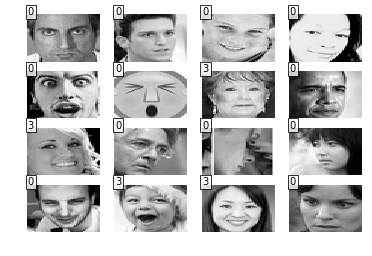

0=Angry 1=Disgust 2=Fear 3=Happy 4=Sad 5=Surprise 6=Neutral


In [48]:
samples = X_test.sample(16)
p = clfs.get(0.001).predict(samples)
plot_sample(samples,48,48,[x.argmax(axis=0) for x in p])

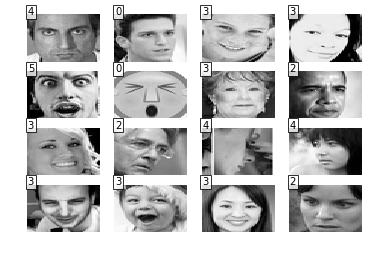

0=Angry 1=Disgust 2=Fear 3=Happy 4=Sad 5=Surprise 6=Neutral


In [49]:
p=y_test.loc[samples.index].as_matrix()
plot_sample(samples,48,48,[x.argmax(axis=0) for x in p])